In [16]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import pickle
import shap
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7 as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

from glob import glob

# Loading the data

In [38]:
train_data_dir = "/kaggle/input/wcebleedgen/Images"

In [39]:
bleed_imgs = os.listdir(os.path.join(train_data_dir, "Bleeding"))
non_bleed_imgs = os.listdir(os.path.join(train_data_dir, "NonBleeding"))
print(len(bleed_imgs))

13090


# Examine some of data

In [40]:
img = image.load_img(os.path.join(train_data_dir, "Bleeding", bleed_imgs[1]))
img_arr = image.img_to_array(img)
print(np.max(img_arr), np.min(img_arr))

254.0 0.0


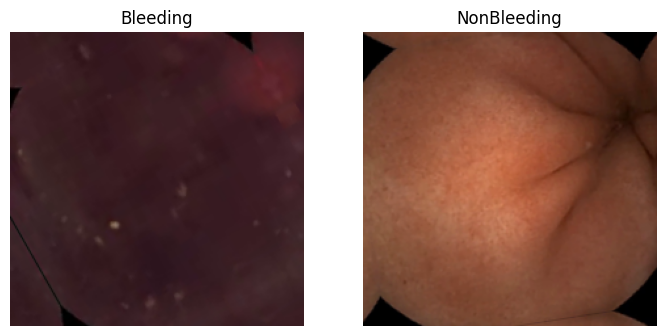

In [41]:
SAMPLES = []
train_folders = os.listdir(train_data_dir)
for f in train_folders:
    folder = os.listdir(os.path.join(train_data_dir, f))
    SAMPLES.append("../input/wcebleedgen/Images" + "/" + f + "/" + folder[0])

plt.figure(figsize=(22, 8)) 
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.title(t[4])
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

# **Training**

In [3]:
#Create an ImageDatagenerator Object with 20% validation split
data_gen = ImageDataGenerator(validation_split=0.2) 

data_gen_aug = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

#The batch size and number of training time(epochs)
BATCH_SIZE = 128 
EPOCHS = 50


#Define the target side of the dataset
X = Y = 224

# Create a train generator with subset='training'
train_ds = data_gen.flow_from_directory(train_data_dir,
                                    class_mode = "binary",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = True,
                                    subset='training',
                                    seed = 42)

Found 2096 images belonging to 2 classes.


### Validation Data

In [4]:
# Use 20% of the original images for validation
VAL_SPLIT = 0.2
val_data_gen = ImageDataGenerator(validation_split = VAL_SPLIT)
validation = val_data_gen.flow_from_directory(val_data_dir,
                                      class_mode = "binary",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                     subset='validation',
                                      seed = 42)

Found 522 images belonging to 2 classes.


# Build The Model

In [ ]:
ptm = PretrainedModel(
    input_shape=(X, Y, 3),
    weights='../input/efficientnet-weights/efficientnetb7_notop.h5',
    include_top=False)

ptm.trainable = False

K = 1

x = GlobalAveragePooling2D()(ptm.output)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

y = Dense(K, activation='sigmoid')(x)

model = Model(inputs=ptm.input, outputs=y)

In [ ]:
#Learning rate schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [ ]:
model.compile(
  loss='binary_crossentropy',
  optimizer= keras.optimizers.Adam(learning_rate=5e-4), 
  metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
checkpoint_path = 'training_1/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

# Train the model over 50 epoch with validation loss being used to monitor the progress and patience of 4 before it halt

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4) 
history = model.fit(
    train_ds,
    validation_data=validation,
    epochs=EPOCHS,
    callbacks=[early_stopping, cp_callback])

# Plot the trained model Accuracy and Loss

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='black')
plt.plot(val_acc, label='Validation Accuracy', color='red')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='black')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()


# Save the model for Reusablility

In [ ]:
# Save the model to a file
with open('wce_model.pkl', 'wb') as file:
    pickle.dump(model, file)


# Load the Saved Model

In [6]:
# Load your saved model from the file that you saved it to
with open('/kaggle/input/wce-model/wce_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Performance Evaluation on the Validation Dataset

In [7]:
# Use the saved model to make prediction on the validation dataset

# Set shuffle to False in the validation generator
validation.shuffle = False

# Get the true labels from the classes attribute
y_true = validation.classes

# Get the predictions from the predict method
predictions = loaded_model.predict(validation)

# Convert the predictions into binary labels using a threshold of 0.5
y_pred = np.rint(predictions)


5/5 [==============================] - 26s 1s/step


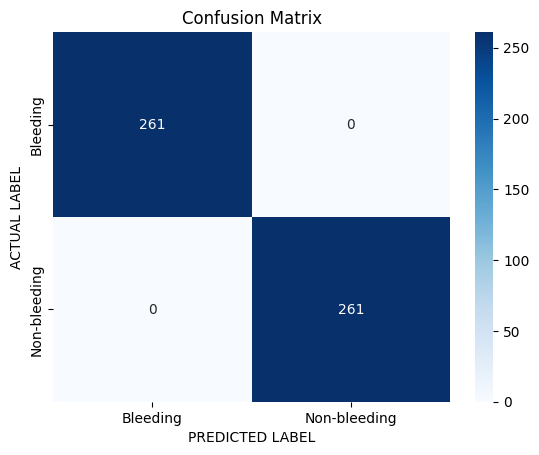

In [17]:
# Plot the Confusion Matrix to see the predicition

cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix with values using seaborn
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, )

# Use custom labels for the x-axis and y-axis ticks
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=["Bleeding", "Non-bleeding"], yticklabels=["Bleeding", "Non-bleeding"])
plt.xlabel("PREDICTED LABEL")
plt.ylabel("ACTUAL LABEL")
plt.title("Confusion Matrix")
plt.show()


In [18]:
# Display the classification report
def evaluate_model(loadedmodel, validation):

    results = loaded_model.evaluate(validation, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    clr = classification_report(validation.labels, y_pred, target_names=["Non-bleeding", "Bleeding"], digits = 4)
    print("Classification Report:\n----------------------\n", clr)
    
evaluate_model(loaded_model, validation)

    Test Loss: 0.00045
Test Accuracy: 100.00%
Classification Report:
----------------------
               precision    recall  f1-score   support

Non-bleeding     1.0000    1.0000    1.0000       261
    Bleeding     1.0000    1.0000    1.0000       261

    accuracy                         1.0000       522
   macro avg     1.0000    1.0000    1.0000       522
weighted avg     1.0000    1.0000    1.0000       522



# Plotting the best 10 prediction on validation dataset

4/4 [==============================] - 1s 337ms/step


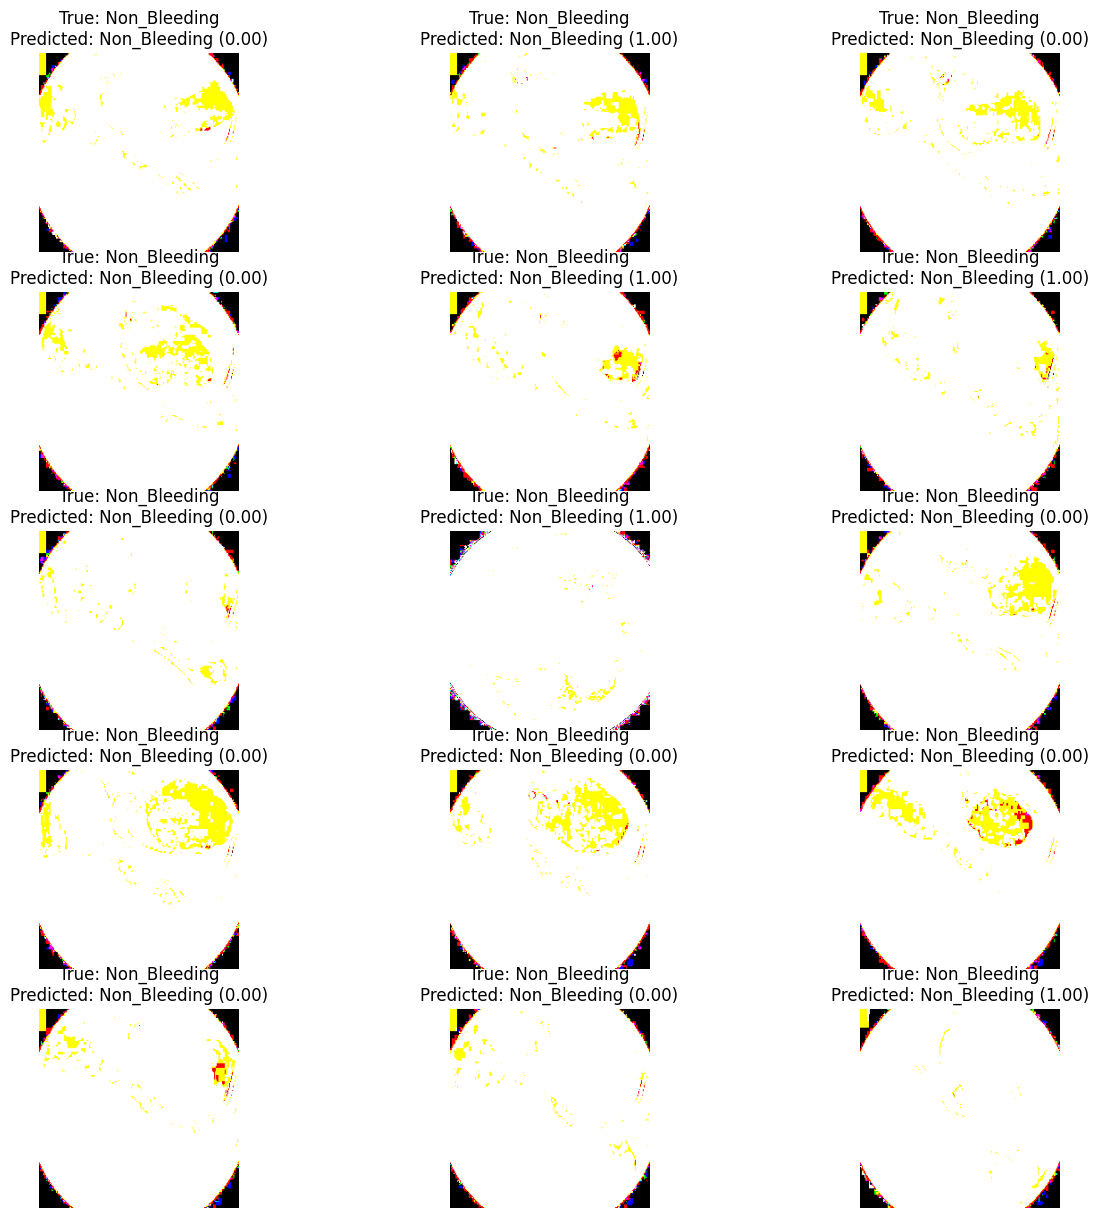

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import random 

# Define the class names
class_names = ["Non_Bleeding", "Bleeding"]

# Get a batch of 10 images and labels from the validation generator
images, labels = validation.next()

# Predict on the batch of images using the loaded model
predictions = loaded_model.predict(images)
pred_labels = np.argmax(predictions, axis=1)
pred_probs = np.max(predictions, axis=1)

# Plot the images, labels, and probabilities
plt.figure(figsize=(15, 15))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i])
    # Convert the labels to integers
    true_label = int(labels[i])
    pred_label = int(pred_labels[i])
    plt.title(f"True: {class_names[true_label]}\nPredicted: {class_names[pred_label]} ({pred_probs[i]:.2f})")
    plt.axis("off")
plt.show()

# Prediction on the Test Dataset using the saved model


In [61]:
# Load your test set from the input directory
test_data_dir = '/kaggle/input/wce-testset/Auto-WCEBleedGen Challenge Test Dataset'
test_data_gen = ImageDataGenerator()
test_set = test_data_gen.flow_from_directory(test_data_dir,
                                              target_size=(X, Y),
                                              color_mode='rgb',
                                              batch_size=BATCH_SIZE,
                                              shuffle=False)

Found 564 images belonging to 2 classes.


In [63]:
# Make predictions on the test set using your model
predictions = loaded_model.predict(test_set)

# Convert the predictions into binary labels using a threshold of 0.5
y_pred = np.rint(predictions)
y_pred = np.where(y_pred == 0, 'non-bleeding', 'bleeding')

5/5 [==============================] - 6s 1s/step


# Save the predictions into an excel file

In [65]:
# Flatten your two-dimensional array into a one-dimensional array before saving to avoid dimensional array error
y_pred = np.ravel(y_pred)
# Save the predictions in an excel file
df = pd.DataFrame({'Image Name': test_set.filenames, 'Predicted class label for each image': y_pred})
df.to_excel('/kaggle/working/predictions1.xlsx', index=False)